<center><h1> MSc in Data Analytics (MSCDA- A) </h1></center>
<center><h2> Modelling, Simulation and Optimisation (H9MSO) Project- CA1 </h2></center>
<center><h3> Mansi Udani </h3></center>
<center><h3> Student Id - x19186088 </h3></center>

## Load Libraries

In [63]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import simpy
import simpy.events as evt
from scipy.optimize import linprog
from simple_colors import *

## Data Preparation 

Initial Dataset has created according to the conditions given in the problem statement.
Description of columns :

**Line** : It is the high speed train line with value 'HS2. There is only one line existing.<br>
**Direction** : is the direction of the train towards the source station which is 'Birmingham' in             this case.<br>
**From** : From Station name ( departure from this station )<br>
**To**   : To station name ( arrival to this station )<br>
**Drive Time** : Time taken by the train to reach from source station to destination station.<br>
**Distance** : Length between two station.<br>

**Drive Time Calculation Assumption** : The distance between 'London Old Oak Common' and 'Birmingham Interchange' is given 145km and drive time is 31 minutes , so by unitary method calculated speed between these two station ( Speed = Distance / Time ).<br>

This block generates time needed for reaching the desired destination with maximum velocity at a given accelration speed.

In [64]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV 

## Data Frame 
This section creates a dataframe based on number of blocks selected 

In [65]:
def data(N):
    data = pd.DataFrame()
    for i in range(N): 
                data.at[i, 'Start_Point'] = 'S' + str(i+1)
                data.at[i, 'End_Point'] = 'S' + str(i+2)
    
    return data

# Utilities

It manipulates the created data frame by calcuating and  adding the new columns like Distance, Actual_Travle_Time, Dwell time

In [66]:
def structure_data(k):
    
    dt = data(k - 1)
            
    
    #Distance is splitted according to the number of blocks
    total_distance = 145000
    distance_split = total_distance / (k - 1)
    
    dt['Distance'] = distance_split
    dt['Actual_Travel_Time'] = ''
    dt['Dwell Time'] = np.random.normal(3.35,0.9, size= k - 1)     
    return dt

This block manipluates the created dataframe by changing the datatype of two
column from text to int and replace the values of two columns with respective station names.

In [67]:
k = 15
dt = structure_data(k)
dt['Distance']=dt['Distance'].apply(lambda x: int(x))
dt['Dwell Time']=dt['Dwell Time'].apply(lambda x: int(x))
dt['Start_Point'] = dt['Start_Point'].replace(['S1'],'London Old Oak Common')
dt['End_Point'] = dt['End_Point'].replace(['S'+str(k)],'Birmingham Interchange')

Calulating the values of Drive time which is time required to reach the destination with meximum velocity

In [68]:
dt['Drive Time'] = timeTo(0.76, 86.1, 145000)/(k-1)
#for i in range(len(dt)):
    #dist = dt.at[i, 'Distance']
   # dt.at[i, 'Drive Time']=int(timeTo(0.76, 86.1, dist))

creating new column by calulating from Dwell time and Drive  Time 

In [69]:
dt['Actual_Travel_Time'] = dt['Dwell Time'] + dt['Drive Time']
dt['Serial_Number'] = dt.index
dt

,Start_Point,End_Point,Distance,Actual_Travel_Time,Dwell Time,Drive Time,Serial_Number
0,London Old Oak Common,S2,10357,133.384125,5,128.384125,0
1,S2,S3,10357,130.384125,2,128.384125,1
2,S3,S4,10357,130.384125,2,128.384125,2
3,S4,S5,10357,131.384125,3,128.384125,3
4,S5,S6,10357,130.384125,2,128.384125,4
5,S6,S7,10357,131.384125,3,128.384125,5
6,S7,S8,10357,131.384125,3,128.384125,6
7,S8,S9,10357,132.384125,4,128.384125,7
8,S9,S10,10357,131.384125,3,128.384125,8
9,S10,S11,10357,129.384125,1,128.384125,9


Deciding startpoint, Endpoint,by cosindering the delay Actual Travel time and Delay time  

In [70]:
class Train(object):
        def __init__(self, i, dt, maxP = 600):
            self.name = ' [Train '+f"{i:2d}"+']'
            self.dt = dt
            self.maxP = maxP
            self.p = 0
     
     
        def process(self):
            for number in self.dt['Serial_Number']:
                count = 0
                data = self.dt[self.dt['Serial_Number'] == number]
                Start_Point = data['Start_Point'].tolist()
                End_Point = data['End_Point'].tolist()
                Start_Point = Start_Point[0]
                End_Point = End_Point[0]
                #print(End_Location)
                for loc in data['Start_Point']:
                    data1=dt[dt['Start_Point'] == loc]
                    streamtime=data1.iloc[0].at['Actual_Travel_Time']
                    dwelltime=data1.iloc[0].at['Dwell Time']
                    #yield env.timeout(dwelltime)
                    #print(Start_Location)
                    print(green (f"{now():s} {self.name:s} dep from {Start_Point:s} for {End_Point:s}"))
                    yield env.timeout(streamtime)
                    print(red (f"{now():s} {self.name:s} arr {End_Point:s}"))

This is giving, start time, end time, time between two trains from starting point by considering the delay in 9 am train

In [71]:
def line1(start=6*3600, stop=10*3600, timing=300):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            if ((32400 - start)/timing) == i:
                yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This is giving, start time, end time, time between two trains from starting point without considering the delay in 9 am train

In [72]:
def line(start=7*3600, stop=10*3600, timing=300):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            #if i==35:
             #   yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This gives the simulation of 47  trains running between 14 blocks with maximum safe velocity and no delay, first straing starting at 06:00:00 am and last traing reaching destination at 10:25:45 am

In [73]:
env = simpy.Environment()   
env.process(line())
env.run()

07:00:00  [Train  0] dep from London Old Oak Common for S2
07:02:13  [Train  0] arr S2
07:02:13  [Train  0] dep from S2 for S3
07:04:23  [Train  0] arr S3
07:04:23  [Train  0] dep from S3 for S4
07:05:00  [Train  1] dep from London Old Oak Common for S2
07:06:34  [Train  0] arr S4
07:06:34  [Train  0] dep from S4 for S5
07:07:13  [Train  1] arr S2
07:07:13  [Train  1] dep from S2 for S3
07:08:45  [Train  0] arr S5
07:08:45  [Train  0] dep from S5 for S6
07:09:23  [Train  1] arr S3
07:09:23  [Train  1] dep from S3 for S4
07:10:00  [Train  2] dep from London Old Oak Common for S2
07:10:55  [Train  0] arr S6
07:10:55  [Train  0] dep from S6 for S7
07:11:34  [Train  1] arr S4
07:11:34  [Train  1] dep from S4 for S5
07:12:13  [Train  2] arr S2
07:12:13  [Train  2] dep from S2 for S3
07:13:07  [Train  0] arr S7
07:13:07  [Train  0] dep from S7 for S8
07:13:45  [Train  1] arr S5
07:13:45  [Train  1] dep from S5 for S6
07:14:23  [Train  2] arr S3
07:14:23  [Train  2] dep from S3 for S4
07:15:0

This gives the simulation of 47  trains running between 14 blocks with maximum safe velocity having  delay constraint oin 9 am train due to tehnical glitch, first straing starting at 06:00:00 am and last traing reaching destination at 10:55:45 am


In [74]:
env = simpy.Environment()   
env.process(line1())
env.run()

06:00:00  [Train  0] dep from London Old Oak Common for S2
06:02:13  [Train  0] arr S2
06:02:13  [Train  0] dep from S2 for S3
06:04:23  [Train  0] arr S3
06:04:23  [Train  0] dep from S3 for S4
06:05:00  [Train  1] dep from London Old Oak Common for S2
06:06:34  [Train  0] arr S4
06:06:34  [Train  0] dep from S4 for S5
06:07:13  [Train  1] arr S2
06:07:13  [Train  1] dep from S2 for S3
06:08:45  [Train  0] arr S5
06:08:45  [Train  0] dep from S5 for S6
06:09:23  [Train  1] arr S3
06:09:23  [Train  1] dep from S3 for S4
06:10:00  [Train  2] dep from London Old Oak Common for S2
06:10:55  [Train  0] arr S6
06:10:55  [Train  0] dep from S6 for S7
06:11:34  [Train  1] arr S4
06:11:34  [Train  1] dep from S4 for S5
06:12:13  [Train  2] arr S2
06:12:13  [Train  2] dep from S2 for S3
06:13:07  [Train  0] arr S7
06:13:07  [Train  0] dep from S7 for S8
06:13:45  [Train  1] arr S5
06:13:45  [Train  1] dep from S5 for S6
06:14:23  [Train  2] arr S3
06:14:23  [Train  2] dep from S3 for S4
06:15:0

# Optimisation

Load Dataset

In [75]:
df=pd.read_csv('optimization.csv')

In [76]:
# Travel Optimization
simulation_data = df
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Number_of_trains'])
predictor = pd.DataFrame(simulation_data[['Number_of_Blocks', 'Average_delay_time', 'time_between_consecutive_trains']])
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

/Users/mansiudani/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Number_of_trains   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     30.23
Date:                Sat, 29 Aug 2020   Prob (F-statistic):            0.00330
Time:                        00:52:39   Log-Likelihood:                -25.206
No. Observations:                   8   AIC:                             58.41
Df Residuals:                       4   BIC:                             58.73
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             231.1701     15.396     15.015      0.000     188.425     273.915
Number_of_Blocks                    1.7341      1.828      0.949      0.396      -3.341       6.809
Average_delay_time                 -0.5916      0.121     -4.882      0.008      -0.928      -0.255
time_between_consecutive_trains     0.0251      0.048      0.527      0.626      -0.107       0.157
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.626
Skew:                          -0.583   Prob(JB):                        0.731
Kurtosis:                       2.280   Cond. No.                     2.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
#linear regression to find objective function
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
 
def f(x,y,z):
    return 231.1701 + 1.7341*x - 0.5916*y + 0.0251*z

# Run Simulaton for Optimisation
Using Monte Carlo

In [78]:
#this monte carlo optimisation for minimising travel time
import random
random.seed(0)
 
def monte_carlo(n, xmin=4, xmax=11, ymin=120, ymax=300, zmin = 300, zmax = 600):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    z = [ random.randint(zmin, zmax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    zp = [ z[0] ]
    fmax = f(xp[0], yp[0],zp[0])
    
    for i in range(1, len(x)):
        if y[i] <= z[i]/2:
            fi = f(x[i], y[i],z[i])
        
            if fi > fmax:
                xp += [x[i]]
                yp += [y[i]]
                zp += [z[i]]
                fmax = fi
 
    xs = np.linspace(xmin, xmax, 100)
    ys = np.linspace(ymin, ymax, 100)
    zs = np.linspace(zmin, zmax, 100)
    xx, yy, zz = np.meshgrid(xs, ys, zs)
    t=f(xx, yy, zz)
    t = t.reshape((-1,100))
    t = t[:100,:]
    fig, ax= plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contour(xs, ys,t,100)
    fig.colorbar(cs, ax=ax)
    
    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #ax.contour3D(xx, yy, t, 100, cmap='binary')
        
    plt.scatter(x, y, c='red', marker='.')
    plt.plot(xp, yp, c='red')
        
    return len(xp), xp[-1], yp[-1], zp[-1], int(f(xp[-1], yp[-1], zp[-1]))

#  Monte Carlo Optimization

(5, 11, 120, 493, 191)

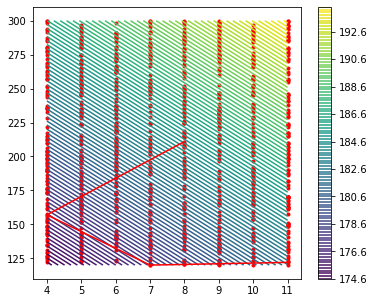

In [79]:
## blocks, Average delay time, time between consecutive train, maximum number of train that cn be run between 7 am to 10 pm
random.seed(30)
monte_carlo(1000)

(6, 9, 123, 575, 188)

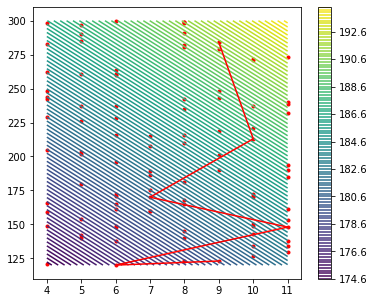

In [80]:
random.seed(150)
monte_carlo(100)

(6, 11, 122, 480, 190)

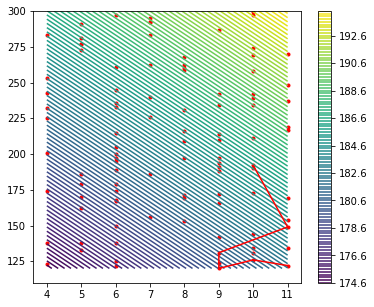

In [81]:
random.seed(130)
monte_carlo(100)

In [82]:
df.head()

,Number_of_Blocks,Number_of_trains,Average_delay_time,time_between_consecutive_trains
0,9,90,300,600
1,4,180,120,300
2,5,105,230,480
3,6,90,280,600
4,7,120,240,480


# Using Linear Programming

In [83]:
from scipy.optimize import linprog
obj = [-231.1701,-1.7341, 0.5916, -0.0251]
#obj = [-222.3718, -3.1466, 0.6799, -0.0665]
lhs_ineq = [[0,0,1,1]]
rhs_ineq = [0.5]
bnd = [(1,1),
       (4, 11),
       (120,300),
       (300,600)]
opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,bounds = bnd, method="revised simplex")

In [84]:
opt

     con: array([], dtype=float64)
     fun: -186.78319999999997
 message: 'The problem appears infeasible, as the phase one auxiliary problem terminated successfully with a residual of 4.2e+02, greater than the tolerance 1e-12 required for the solution to be considered feasible. Consider increasing the tolerance to be greater than 4.2e+02. If this tolerance is unnaceptably large, the problem is likely infeasible.'
     nit: 0
   slack: array([-419.5])
  status: 2
 success: False
       x: array([  1.,  11., 120., 300.])